In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_wr_backtest_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

10252


### Split data into train/test/validation

In [5]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

10252


In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']

# FOUND USING RFE IN RESEARCH NOTEBOOK
#features = ['6GameRecTargetsPerTeamPlay','6GameRecYardsPerTeamPlay','CareerAvgRecYards',
#            'CareerRecYardsPerTeamPlay','SeasonAvgRecYards','SeasonAvgReceptions','SeasonRecTargetsPerTeamPlay',
#            'SeasonRecYardsPerTeamPlay','SeasonTeamPassYardsPerCompAllowed']

all_features = features + [target_variable]

In [8]:
train_test_data = raw_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [9]:
X.shape

(10252, 539)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.45334816637130043, 'gamma': 0.01836068125041057, 'learning_rate': 0.053210301652276554, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 390, 'reg_alpha': 0.4385384885374355, 'reg_lambda': 2.186098343541303, 'subsample': 0.6983984235431582}
Best Score (R-squared): 0.25393109206660613
Test R-squared: 0.24984550110802095
Test RMSE: 31.8103
Test MAE: 24.6868


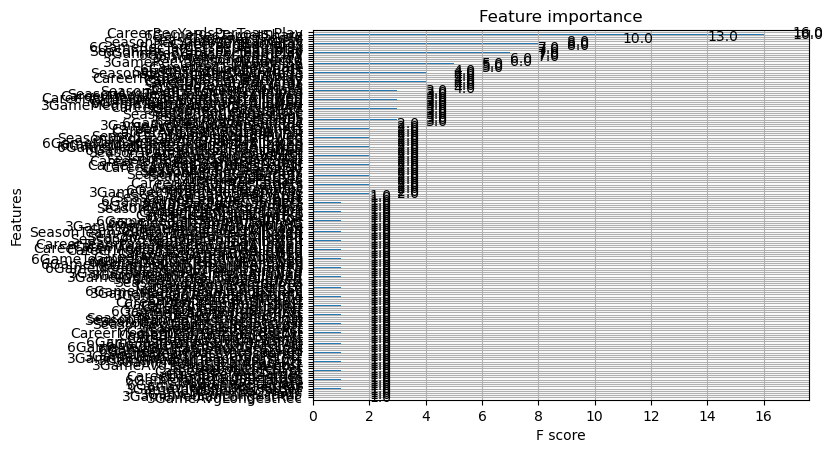

,TargetRecYards,pred_TargetRecYards,residuals
3404,18.0,27.193373,-9.193373
7630,3.0,36.746269,-33.746269
1402,104.0,37.212837,66.787163
9031,19.0,23.201252,-4.201252
8122,30.0,37.827168,-7.827168


In [10]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=500, 
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()

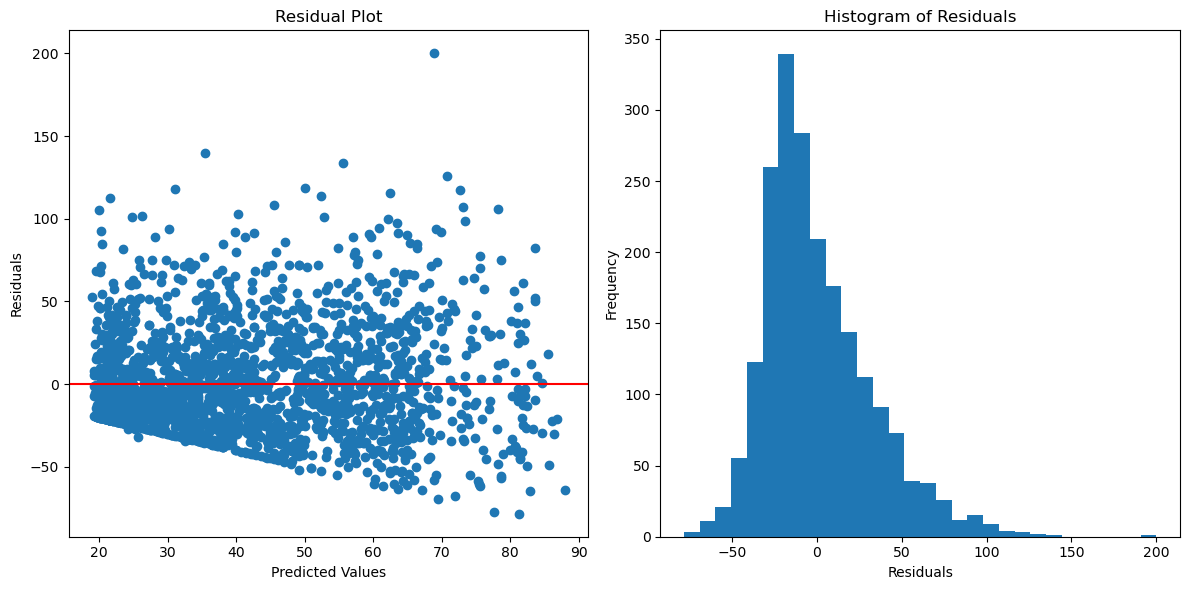

In [11]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

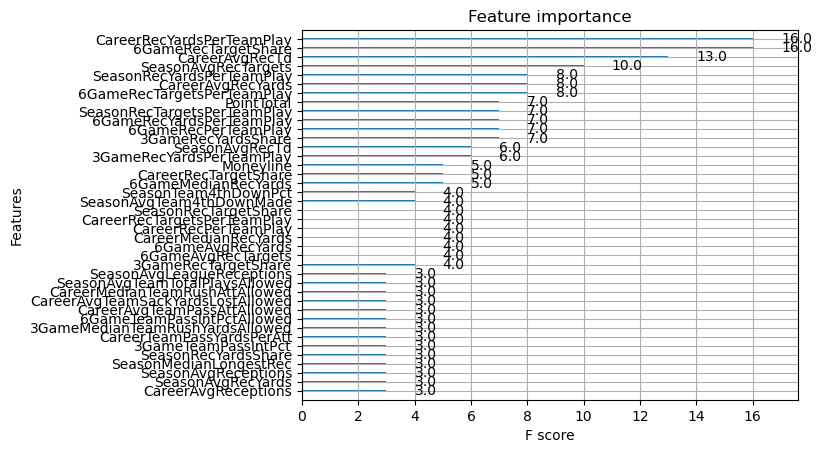

<Figure size 1800x1200 with 0 Axes>

In [12]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

### Persist the best model in the models dir

In [13]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_wr_backtest.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_wr_backtest.pkl']

In [14]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_wr_backtest.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

In [32]:
test = pd.DataFrame(X_test.loc[170]).T

test

,3GameAvgLongestRec,3GameAvgRecTargets,3GameAvgRecTd,3GameAvgRecYards,3GameAvgReceptions,3GameCatchPct,3GameMedianLongestRec,3GameMedianRecTargets,3GameMedianRecTd,3GameMedianRecYards,3GameMedianReceptions,3GameRecPerTeamPlay,3GameRecShare,3GameRecTargetShare,3GameRecTargetsPerTeamPlay,3GameRecYardsPerTeamPlay,3GameRecYardsShare,3GameYardsPerRecTarget,3GameYardsPerRush,6GameAvgLongestRec,6GameAvgRecTargets,6GameAvgRecTd,6GameAvgRecYards,6GameAvgReceptions,6GameCatchPct,6GameMedianLongestRec,6GameMedianRecTargets,6GameMedianRecTd,6GameMedianRecYards,6GameMedianReceptions,6GameRecPerTeamPlay,6GameRecShare,6GameRecTargetShare,6GameRecTargetsPerTeamPlay,6GameRecYardsPerTeamPlay,6GameRecYardsShare,6GameYardsPerRecTarget,6GameYardsPerRush,CareerAvgLongestRec,CareerAvgRecTargets,CareerAvgRecTd,CareerAvgRecYards,CareerAvgReceptions,CareerCatchPct,CareerMedianLongestRec,CareerMedianRecTargets,CareerMedianRecTd,CareerMedianRecYards,CareerMedianReceptions,CareerPerRecTarget,CareerRecPerTeamPlay,CareerRecShare,CareerRecTargetShare,CareerRecTargetsPerTeamPlay,CareerRecYardsPerTeamPlay,CareerRecYardsShare,CareerYardsPerRec,SeasonAvgLongestRec,SeasonAvgRecTargets,SeasonAvgRecTd,SeasonAvgRecYards,SeasonAvgReceptions,SeasonCatchPct,SeasonMedianLongestRec,SeasonMedianRecTargets,SeasonMedianRecTd,SeasonMedianRecYards,SeasonMedianReceptions,SeasonPerRecTarget,SeasonRecPerTeamPlay,SeasonRecShare,SeasonRecTargetShare,SeasonRecTargetsPerTeamPlay,SeasonRecYardsPerTeamPlay,SeasonRecYardsShare,SeasonYardsPerRec,3GameAvgTeamNetPassYards,3GameAvgTeamPassAtt,3GameAvgTeamPassComp,3GameAvgTeamPassInt,3GameAvgTeamPassTd,3GameAvgTeamPassYards,3GameAvgTeamSackYardsLost,3GameAvgTeamTimesSacked,3GameMedianTeamNetPassYards,3GameMedianTeamPassAtt,3GameMedianTeamPassComp,3GameMedianTeamPassInt,3GameMedianTeamPassTd,3GameMedianTeamPassYards,3GameMedianTeamSackYardsLost,3GameMedianTeamTimesSacked,3GameTeamAdjPassYardsPerAtt,3GameTeamPassCompPct,3GameTeamPassIntPct,3GameTeamPassTdPct,3GameTeamPassYardsPerAtt,3GameTeamPassYardsPerComp,6GameAvgTeamNetPassYards,6GameAvgTeamPassAtt,6GameAvgTeamPassComp,6GameAvgTeamPassInt,6GameAvgTeamPassTd,6GameAvgTeamPassYards,6GameAvgTeamSackYardsLost,6GameAvgTeamTimesSacked,6GameMedianTeamNetPassYards,6GameMedianTeamPassAtt,6GameMedianTeamPassComp,6GameMedianTeamPassInt,6GameMedianTeamPassTd,6GameMedianTeamPassYards,6GameMedianTeamSackYardsLost,6GameMedianTeamTimesSacked,6GameTeamAdjPassYardsPerAtt,6GameTeamPassCompPct,6GameTeamPassIntPct,6GameTeamPassTdPct,6GameTeamPassYardsPerAtt,6GameTeamPassYardsPerComp,CareerAvgTeamNetPassYards,CareerAvgTeamPassAtt,CareerAvgTeamPassComp,CareerAvgTeamPassInt,CareerAvgTeamPassTd,CareerAvgTeamPassYards,CareerAvgTeamSackYardsLost,CareerAvgTeamTimesSacked,CareerMedianTeamNetPassYards,CareerMedianTeamPassAtt,CareerMedianTeamPassComp,CareerMedianTeamPassInt,CareerMedianTeamPassTd,CareerMedianTeamPassYards,CareerMedianTeamSackYardsLost,CareerMedianTeamTimesSacked,CareerTeamAdjPassYardsPerAtt,CareerTeamPassCompPct,CareerTeamPassIntPct,CareerTeamPassTdPct,CareerTeamPassYardsPerAtt,CareerTeamPassYardsPerComp,SeasonAvgTeamNetPassYards,SeasonAvgTeamPassAtt,SeasonAvgTeamPassComp,SeasonAvgTeamPassInt,SeasonAvgTeamPassTd,SeasonAvgTeamPassYards,SeasonAvgTeamSackYardsLost,SeasonAvgTeamTimesSacked,SeasonMedianTeamNetPassYards,SeasonMedianTeamPassAtt,SeasonMedianTeamPassComp,SeasonMedianTeamPassInt,SeasonMedianTeamPassTd,SeasonMedianTeamPassYards,SeasonMedianTeamSackYardsLost,SeasonMedianTeamTimesSacked,SeasonTeamAdjPassYardsPerAtt,SeasonTeamPassCompPct,SeasonTeamPassIntPct,SeasonTeamPassTdPct,SeasonTeamPassYardsPerAtt,SeasonTeamPassYardsPerComp,3GameAvgTeamRushAtt,3GameAvgTeamRushTd,3GameAvgTeamRushYards,3GameMedianTeamRushAtt,3GameMedianTeamRushTd,3GameMedianTeamRushYards,3GameTeamRushTdPct,3GameTeamYardsPerRush,6GameAvgTeamRushAtt,6GameAvgTeamRushTd,6GameAvgTeamRushYards,6GameMedianTeamRushAtt,6GameMedianTeamRushTd,6GameMedianTeamRushYards,6GameTeamRushTdPct,6GameTeamYardsPerRush,CareerAvgTeamRushAtt,CareerAvgTea

In [28]:
test.to_dict()

{'3GameAvgLongestRec': {170: 30.33333333333333},
 '3GameAvgRecTargets': {170: 3.0},
 '3GameAvgRecTd': {170: 0.6666666666666666},
 '3GameAvgRecYards': {170: 47.66666666666666},
 '3GameAvgReceptions': {170: 2.6666666666666665},
 '3GameCatchPct': {170: 0.8888888888888888},
 '3GameMedianLongestRec': {170: 18.0},
 '3GameMedianRecTargets': {170: 3.0},
 '3GameMedianRecTd': {170: 1.0},
 '3GameMedianRecYards': {170: 44.0},
 '3GameMedianReceptions': {170: 2.0},
 '3GameRecPerTeamPlay': {170: 0.0416666666666666},
 '3GameRecShare': {170: 0.1025641025641025},
 '3GameRecTargetShare': {170: 0.0841121495327102},
 '3GameRecTargetsPerTeamPlay': {170: 0.046875},
 '3GameRecYardsPerTeamPlay': {170: 0.7447916666666666},
 '3GameRecYardsShare': {170: 0.1556039173014145},
 '3GameYardsPerRecTarget': {170: 15.88888888888889},
 '3GameYardsPerRush': {170: 17.875},
 '6GameAvgLongestRec': {170: 26.166666666666668},
 '6GameAvgRecTargets': {170: 2.833333333333333},
 '6GameAvgRecTd': {170: 0.5},
 '6GameAvgRecYards': {17

In [29]:
best_xgb.predict(test)

array([33.11311], dtype=float32)

In [30]:
len(features)

539

In [33]:
len(X.loc[0].values)

539

In [34]:
fedatures

NameError: name 'fedatures' is not defined